In [23]:
# import block
import pandas as pd
import numpy as np
import pyomo.environ as pyo
import matplotlib.pyplot as plt

In [24]:
# load raw train data
# parse data
data = None
try:
    with open('data/DebrisFlow.txt', 'r') as f:
        data = f.read()
except:
    print('Error reading file')
if data is not None:
    # split data into lines
    data = data.split('\n')
    # remove empty lines
    data = [line for line in data if line != '']
    # split lines into columns
    data = [line.split('\t') for line in data]
    # convert to numpy array
    data = np.array(data, dtype=np.float64)

In [ ]:
# function to plot the model results
def plot_model_results(data: np.ndarray, c_res: list, d_res: list, delta_res: list = None):
    '''
     Plots the model results against the data

     IMPORTANT
     ---------
     provide c, d and delta values in a list even if there is only one value

     Parameters
     ==========
          - data: the data to plot
          - c_res: the c results (slope)
          - d_res: the d results (intercept)
          - delta_res: the delta results (segment number for each data point)

     Returns
     =======
     None
    '''

    fig = plt.figure(figsize=(10, 5))
    if delta_res is None:
      plt.plot(data[:,0], data[:,1], 'k.')
      plt.plot(data[:,0], [c_res[0]*data[i,0]+d_res[0] for i in range(data.shape[0])])
    else:
      colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
      marker_options = ['o', 'v', '^', 's', 'p', '*', '+', 'x']
      segment_list = np.unique(delta_res)
      data_length = data.shape[0]

      y_pred = [[c_res[b]*data[i,0]+d_res[b] for i in range(data_length)] for b in segment_list]
      x_segmented = {b:[] for b in segment_list}
      y_true_segmented = {b:[] for b in segment_list}
      y_pred_segmented = {b:[] for b in segment_list}

      for i in range(data_length):
        segment = delta_res[i]
        x_segmented[segment].append(data[i,0])
        y_true_segmented[segment].append(data[i,1])
        y_pred_segmented[segment].append(c_res[segment]*data[i,0] + d_res[segment])

      # plot the model results
      # plot the data
      for segment in x_segmented.keys():
          plt.plot(x_segmented[segment],y_true_segmented[segment], color='k',linewidth=0, marker=marker_options[segment], markerfacecolor='none')
      for y in y_pred:
          plt.plot(data[:,0],y, linestyle='--', linewidth=0.5, color='k')
      # plot the model results
      for segment in x_segmented.keys():
          plt.plot(x_segmented[segment], y_pred_segmented[segment],color = colors[segment], linestyle='-', linewidth=1,
                  label=f'Model Results for segment {segment}')

    plt.xlabel('Distance (m)')
    plt.ylabel('Debris Flow (m)')
    # set the legend
    plt.legend()
    # show the plot
    plt.show()

In [ ]:
CBOUND = (min(abs((data[i, 1]-data[j, 1])/(data[i, 0]-data[j, 0]))
              for i in range(data.shape[0]) for j in range(data.shape[0]) if i > j),
          max(abs((data[i, 1]-data[j, 1])/(data[i, 0]-data[j, 0]))
              for i in range(data.shape[0]) for j in range(data.shape[0]) if i > j)
          )

d_lower_list = [data[i, 1] - CBOUND[1]*data[i, 0]
                for i in range(data.shape[0])]
d_lower_list.extend([data[i, 1] - CBOUND[0]*data[i, 0]
                    for i in range(data.shape[0])])

d_upper_list = [data[i, 1] - CBOUND[0]*data[i, 0]
                for i in range(data.shape[0])]
d_upper_list.extend([data[i, 1] - CBOUND[1]*data[i, 0]
                    for i in range(data.shape[0])])

DBOUND = (min(d_lower_list), max(d_upper_list))

print('Bounds for C', CBOUND)
print('Bounds for D', DBOUND)
M1 = [
    max(
        abs(data[i, 1]-CBOUND[1]*data[i, 0]-DBOUND[1]),
        abs(data[i, 1]-CBOUND[0]*data[i, 0]-DBOUND[0]),
        abs(data[i, 1]-CBOUND[0]*data[i, 0]-DBOUND[1]),
        abs(data[i, 1]-CBOUND[1]*data[i, 0]-DBOUND[0]))
    for i in range(data.shape[0])
]

M2=[(DBOUND[1] - DBOUND[0] - data[i,0]*(CBOUND[0]-CBOUND[1])) for i in range(data.shape[0])]

Bounds for C (0.0, 0.2858829471413148)
Bounds for D (-105.77653624065739, 37.16493733)


# Models

### Model 1: Linear Regression
This model represents a simple classic linear regression with mean absolute error as measure for loss.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


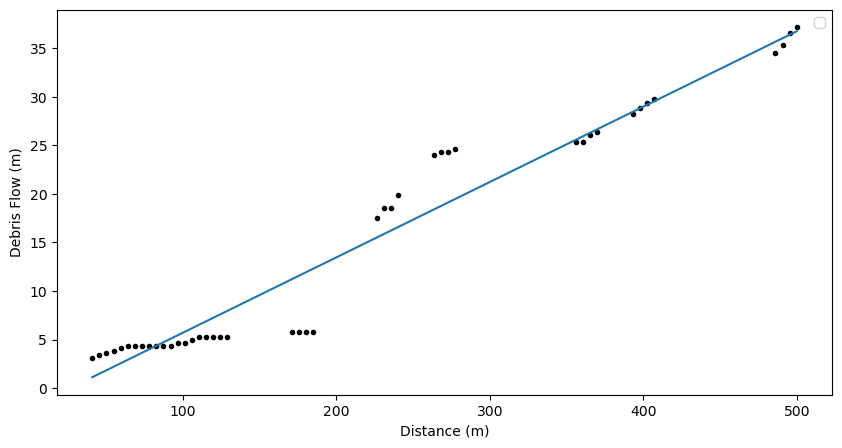

In [ ]:
# standard model for linear regression P17top section2
model = pyo.ConcreteModel()

# sets
model.add_component('I', pyo.Set(initialize=range(data.shape[0])))

# define the variables
model.add_component('ksi', pyo.Var(model.I, domain=pyo.NonNegativeReals))
model.add_component('c', pyo.Var(domain=pyo.Reals, bounds=CBOUND))
model.add_component('d', pyo.Var(domain=pyo.Reals, bounds=DBOUND))

# define the objective function


def obj_func_rule(model):
    return sum((model.ksi[i] for i in model.I))


model.add_component('obj_func', pyo.Objective(
    rule=obj_func_rule, sense=pyo.minimize))

# define the constraints


def constr1_rule(model, i):
    return data[i, 1] - model.c*data[i, 0] - model.d <= model.ksi[i]


model.add_component('constr1', pyo.Constraint(model.I, rule=constr1_rule))


def constr2_rule(model, i):
    return model.c*data[i, 0] + model.d - data[i, 1] <= model.ksi[i]


model.add_component('constr2', pyo.Constraint(model.I, rule=constr2_rule))

# solve the model
solver = pyo.SolverFactory('glpk')
results = solver.solve(model)

# plot the results
plot_model_results(data, [pyo.value(model.c)], [pyo.value(model.d)])

---
### Model 2: Clusterwise Linear Regression (quadratically constrained convex)

This model is a MILP simultaneously clusters the data and fits a linear regression model to each cluster.

In [ ]:
# model 2 P18top section2.1
model = pyo.ConcreteModel()

SEGMENT_COUNT = 1 # max resources limit

# sets
model.add_component('I', pyo.Set(initialize=range(data.shape[0])))
model.add_component('B', pyo.Set(initialize=range(SEGMENT_COUNT)))

# define the parameters
model.add_component('M', pyo.Param(model.I, initialize=M1))

# define the variables
model.add_component('ksi', pyo.Var(model.I, domain=pyo.NonNegativeReals))
model.add_component('delta', pyo.Var(model.I, model.B, domain=pyo.Binary))
model.add_component('c', pyo.Var(model.B, domain=pyo.Reals, bounds=CBOUND))
model.add_component('d', pyo.Var(model.B, domain=pyo.Reals, bounds=DBOUND))

# define the objective functio
def obj_func_rule(model):
    return sum(model.ksi[i] for i in model.I)
model.add_component('obj_func', pyo.Objective(
    rule=obj_func_rule, sense=pyo.minimize))


# define the constraints
# absolute value constraint
def con1_rule(model, i, b):
    return data[i, 1] - (model.c[b] * data[i, 0] + model.d[b]) <= model.ksi[i] + model.M[i] * (1 - model.delta[i, b])
model.con1 = pyo.Constraint(model.I, model.B, rule=con1_rule)

def con2_rule(model, i, b):
    return model.c[b] * data[i, 0] + model.d[b] - data[i, 1] <= model.ksi[i] + model.M[i] * (1 - model.delta[i, b])
model.con2 = pyo.Constraint(model.I, model.B, rule=con2_rule)

# cluster constraint
def con3_rule(model, i):
    return sum(model.delta[i, b] for b in model.B) == 1
model.con3 = pyo.Constraint(model.I, rule=con3_rule)

# minimum number of points in a cluster
def con4_rule(model, b):
    # let n (minimum number of points in a cluster) be 1
    return sum(model.delta[i, b] for i in model.I) >= 1
model.add_component('con4', pyo.Constraint(model.B, rule=con4_rule))

# solve the model
solver = pyo.SolverFactory('glpk')
results = solver.solve(model)

# plot the results
plot_model_results(data, [pyo.value(model.c[b]) for b in model.B], [pyo.value(model.d[b]) for b in model.B], [
                   b for b in model.B for i in model.I if pyo.value(model.delta[i, b]) == 1])